# Lab 2 : Classification

### Group 3 - Members:

_Tai Chowdhury_<br>
_Apurv Mittal_<br>
_Ravi Sivaraman_<br>
_Seemant Srivastava_<br>


## Introduction

As discussed in Lab 1, we have acquired the Australian Weather dataset from Kaggle portal. It contains 10 years of weather data collected from many locations across Australia. These are daily weather observations. There are 145,459 observations with 23 attributes in the original dataset. 

We have chosen RainTomorrow (categorical) and Rainfall (continuous) as predictor variables. RainTomorrow is a categorical attribute which indicates whether it is going to rain tomorrow - yes or no. Rainfall is a continuous attribute that measures amount of rainfall each of the particular locations have received (in mm). Using our models, we will be able to design an algorithm where the bureau can help to predict rainfall for different regions in Australia.

In this Lab 2 assignment, we have measured the accuracy and effectiveness of our model for categorical variable RainTomorrow by using 10-fold cross validation against the confusion matrix measurements like: Precision, Recall and Accuracy. We have explored the methods of logistic regression and support vector machine (SVM) models on our dataset. 

We have used `scikit-learn` packages for our exploration. We ran logistic regression models with all the available solvers in the `scikit-learn` package and compare the effictiveness and accuracy of the model to predict `RainfallTomorrow`. We also measured the duration of model run from each models to compare model performance and efficiency as well.
 
To get started, we will start with loading all the necessary packages for our analysis. We will start our analysis with `df_impute` which is the imputed dataframe from our last explanatory data analysis Lab 1 project. Using this dataframe will ensure data consistency for all the labs going forward.

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy import stats
import warnings
from shapely.geometry import Point
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [2]:
#Ignore Warnings on final

warnings.filterwarnings('ignore')

## Data Preperation
We imputed data in EDA and reusing imputed data from EDA (Lab1) project.
Here is the link to the EDA

https://nbviewer.jupyter.org/github/ravisiv/AussieWeatherEDA/blob/c0ba412cb75da21eba386ea9ea39f645ad6af1d0/DS7331_Lab1_Group3_Ravi_Taifur_Seemant_Apurv_Submission.ipynb


In [3]:
# Read the Imputed Australia weather data
df_impute = pd.read_csv("weatherAUS_imputed.csv")

In [4]:
#  View the top rows of the data imported
df_impute.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,6.032209,8.890686,W,44.0,W,WNW,20.0,...,71.0,22.0,1007.7,1007.1,8.000000,3.684394,16.9,21.8,No,No
1,7.4,25.1,0.0,6.032209,8.890686,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,3.635105,3.684394,17.2,24.3,No,No
2,12.9,25.7,0.0,6.032209,8.890686,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,3.635105,2.000000,21.0,23.2,No,No
3,9.2,28.0,0.0,6.032209,8.890686,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,3.635105,3.684394,18.1,26.5,No,No
4,17.5,32.3,1.0,6.032209,8.890686,W,41.0,ENE,NW,7.0,...,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No


The imputed data doesn't include any null or missing values. Also, we have dropped the columns like: Date of observation and City Name.

In [5]:
df_impute_num = df_impute.columns[df_impute.dtypes == 'float64']
df_impute_cat=df_impute.columns[df_impute.dtypes == 'object']
print("Numeric Variables:", df_impute_num)
print("Categorical Variables:", df_impute_cat)

Numeric Variables: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')
Categorical Variables: Index(['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'], dtype='object')


Before continuing further, we need to check which variables are numeric and which are not. As the models expect numerical variables. We will filter and identify non-numeric variables.

`WindGustDir`, `WindDir9am`, `WindDir3pm`, `RainToday` and `RainTomorrow`are not numeric. Here `RainTomorrow` is our response variable. we handle the other variables with hot-one-encoding later in the flow.

In [6]:
#Keep the original data
df_model = df_impute.copy()

Creating a new DataFrame `df_model` for modeling to avoid any changes to the original dataset `df_impute`.

In [7]:
# Create a new variable to Identify if it RainToday

df_model["IsRainToday"] = df_impute['RainToday']

# Replacing No with 0 and Yes with 1.

df_model['IsRainToday'].replace({'No': 0, 'Yes': 1},inplace = True)


Assigning `0` to No values and `1` to Yes values in `RainToday` (Changed to `IsRainToday`)

In [8]:
print("df_impute", df_impute.shape)
print("df_model", df_model.shape)


df_impute (140787, 21)
df_model (140787, 22)


In [9]:
# Printing the values to check if the data looks good

df_model.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,IsRainToday
0,13.4,22.9,0.6,6.032209,8.890686,W,44.0,W,WNW,20.0,...,22.0,1007.7,1007.1,8.000000,3.684394,16.9,21.8,No,No,0
1,7.4,25.1,0.0,6.032209,8.890686,WNW,44.0,NNW,WSW,4.0,...,25.0,1010.6,1007.8,3.635105,3.684394,17.2,24.3,No,No,0
2,12.9,25.7,0.0,6.032209,8.890686,WSW,46.0,W,WSW,19.0,...,30.0,1007.6,1008.7,3.635105,2.000000,21.0,23.2,No,No,0
3,9.2,28.0,0.0,6.032209,8.890686,NE,24.0,SE,E,11.0,...,16.0,1017.6,1012.8,3.635105,3.684394,18.1,26.5,No,No,0
4,17.5,32.3,1.0,6.032209,8.890686,W,41.0,ENE,NW,7.0,...,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No,0


We can observe that the presence of “0” and “1” is almost in the 78:22 ratio. So there is a class imbalance and we have to deal with it. To fight against the class imbalance, we will use here the oversampling of the minority class. Since the size of the dataset is quite small, majority class subsampling wouldn’t make much sense here.

## One-hot encoding

Before we create our models, we need to format our attributes. We are converting `RainToday` and `RainTomorrow` into numeric variables to `0` and `1`. We also decided to go ahead with one-hot-encoding `WindGustDir`, `WindDir9am`, and `WindDir3pm` attributes based on the direction of the wind. 

In [10]:
# perform one-hot encoding using dummies

gust_df = pd.get_dummies(df_model.WindGustDir,prefix='GustDir', drop_first= True)
wind3pm_df = pd.get_dummies(df_model.WindDir3pm,prefix='Wind3pm', drop_first= True)
wind9am_df = pd.get_dummies(df_model.WindDir9am,prefix='Wind9am' , drop_first= True)
df_model = pd.concat((df_model,gust_df, wind3pm_df, wind9am_df),axis=1) # add back into the dataframe


We decided to do one-hot-encoding using dummies function as machine learning algorithms and models requires numerical values for both input and output attributes.

In [11]:
# Drop categorical columns

df_model = df_model.drop(['WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainToday'], axis = 1)

After conversions, we are removing these categorical attributes to avoid duplicates as we have those data in numerical format. We are added the newly formatted attributes and rest of the continuous attributes into a new dataframe - df_model. We will use the new dataframe for modeling.

Reference: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [12]:
#Check if Yes is replaced as 1

print("Are there 1's and 0's in the RainToday column?", 
      (df_model['IsRainToday'].sum() > 0) and (df_model['IsRainToday'].sum() < len(df_model['IsRainToday'])))

#Non zero output means there is a mixture of 1's and 0's


Are there 1's and 0's in the RainToday column? True


Checking if the data imputation happened accurately.

In [13]:
df_model_num = df_model.columns[df_model.dtypes == 'float64']
df_model_cat=df_model.columns[df_model.dtypes == 'object']
print("Numeric Variables:", df_model_num)
print("Categorical Variables:", df_model_cat)

Numeric Variables: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')
Categorical Variables: Index(['RainTomorrow'], dtype='object')


Check if all the numerical variables are accurately created and if we still have any non-numeric data.

In [14]:
X=df_model[df_model_num]
y = df_model.RainTomorrow
print('features shape:', X.shape) 
print('target shape:', y.shape )

features shape: (140787, 16)
target shape: (140787,)


Assigning the `RainTomorrow` as our response variable (y) and all other variables include one-hot-encoded values as X.

### Data Distribution

Check if the data distribution is balanced or not for the response variable `RainTomorrow`.

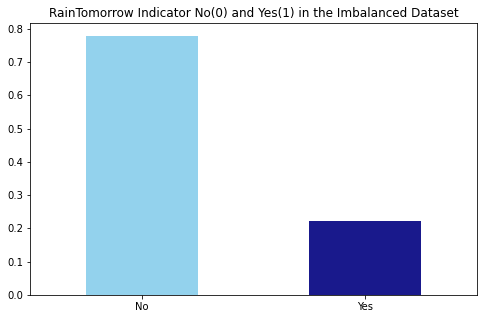

In [15]:
fig = plt.figure(figsize = (8,5))
df_model['RainTomorrow'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

As expected, we see the data for `RainTomorrow` is imbalanced. Majority of the data is for `No` rain vs. `Yes` for `RainTomorrow`.

We can observe that the presence of `0` and `1` is almost in the `78:22` ratio. We will be cognizant of the fact that our model may be not very effective if we don't solve for imbalance. We will discuss and adjust for this imbalance in our analysis.

# Modeling and Evaluation

### Explanation of Evaluation Matrices

#### Macro Avg vs Weight Avg Precision comparisons

As we couldn't pick the models just from Accuracy, we are further our analysis by plotting the difference between the Macro Avg precision and Weighted Avg precision for all the models.

`DiffMacro/WeightedNone` — takes the Macro Average and Weighted Average of Precision from the classification matrix and calculates the difference. The reason to calculate the difference is to check how much variation is in the Precision values based on how the data is split.

`DiffMacro/WeightedBalanced` — same as above this variable calculates the difference between Macro and Weighted Average of Precision of a balanced data.

The smaller the difference between Weight Avg and Macro Avg, the model is closer to real world and also consistent.

After running the big `Logistic Regression` model for several combinations. We got output for 660 models.

To compare the outputs and make it easier to identify the most appropriate model in terms of accuracy, precision and other factors applicable for Machine Learning models. We decided to put a list of subset of variables including:

`Model` — specifies which technique was used for the logistic model. In this case its between ShuffleSplit and Stratified.

`AccuracyNone` —  specifies the Accuracy observed by the model where data was not `balanced`.

`DiffMacro/WeightedNone` — takes the `Macro Average` and `Weighted Average` of `Precision` from the classification matrix and calculates the difference. The reason to calculate the difference is to check how much variation is in the Precision values based on how the data is split. More details about Precision and Averages is provided below. This variation is calculated on the non `balanced` data.

`AccuracyBalanced` — specifies the Accuracy observed by the model where data was `balanced`.

`DiffMacro/WeightedBalanced` — same as above this variable calculates the difference between Macro and Weighted Average of Precision of a `balanced` data.

### Important Terms

`Accuracy` — is a ratio of correctly predicted observation to the total observations. It is a very important aspect to define the success of a model but just the measurement on its own can be deceiving if the observations are not equal for each class. In such cases we might be predicting accurately for one particular class with large observation and may not do very well for other classes.

`Precision` — is the ratio of correctly predicted positive observations to the total predicted positive observations. Precision = TP/TP+FP  

`Weighted Average` — can be calculated on various output variables of the classification report like Precision, Recall, f1-score. As the name suggests it gives the weighted average of the parameter based on the number of observations or values for each class.

`Macro Average` — similar to weighted average, macro average can also be calculated on various output variables of the classification report like Precision, Recall, f1-score. However, the similarity ends here as unlike weighted average, we don't use weights based on the number of observations, rather equal weights are given to each class to calcualte the value. This tells us if the Precision is as good if the dataset was balanced.

References:
https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report

### Cross Validation

In these models we used two different methodologies for cross validation namely `Shuffle` and `Stratified`.

`ShuffleSplit`  — is similar to `Cross Validation` where we can specify the percentage of split for train and test data. However, in regular cross-validation, the data is not split randomly, so, it is good to shuffle the targets before applying the `cross-validation`.


`Stratified` — CV technique is very useful with unbalanced dataset. As discussed above our dataset is not balanced and rightly so, we don't expect it to rain and no-rain days to be equal in Australia. The data is expected to be unbalanced and expected to be such in future as well. So using stratified sampling techniques gives us the ability to preserve the proportion of the Rain days vs non-rain days in our dataset. We can be confident that the Train and Test split data is not leaving out important information like entire dataset is of `No` rain days which will give highly inaccurate output eventhough the accuracy might be maintained. 

In `Stratified` sampling, the data is k-1 split in favor of Train vs Test data.


References: 
https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d
https://mclguide.readthedocs.io/en/latest/sklearn/cv.html


### Logistic Regression Model

### Creating Logistic Regression Function

The function below creates models with various parameters supported by LogisticRegression. There are various combinations of
1. `Model Type`
2. `Class Weight`
3. `Solver`
4. `C`
5. `Penalty`
6. `Iterations`

This function runs for specific Solver, C, Penalty but takes various iterations, and we used 10 iterations.
When this function called with Solver, C, Penalty, the function runs for BOTH Class Weight, `balanced` and `None`. The result of both `balanced` and `None` is stored as single row in a dataframe.
They are stored in the same row to verify how `balanced` and `None` compares.

##### Model Type

1. `Shuffle`
2. `Stratified`

`ShuffleSplit`  — is similar to `Cross Validation` where we can specify the percentage of split for train and test data. However, in regular cross-validation, the data is not split randomly, so, it is good to shuffle the targets before applying the `cross-validation`.


`Stratified` — CV technique is very useful with unbalanced dataset. As discussed above our dataset is not balanced and rightly so, we don't expect it to rain and no-rain days to be equal in Australia. The data is expected to be unbalanced and expected to be such in future as well. So using stratified sampling techniques gives us the ability to preserve the proportion of the Rain days vs non-rain days in our dataset. We can be confident that the Train and Test split data is not leaving out important information like entire dataset is of `No` rain days which will give highly inaccurate output eventhough the accuracy might be maintained. 

In `Stratified` sampling, the data is k-1 split in favor of Train vs Test data.


References: 
https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d
https://mclguide.readthedocs.io/en/latest/sklearn/cv.html


##### Solver Options
Scikit-learn comes with five different solver options. Each solver minimize the cost function. Here are the five options:

`newton-cg` — A newton method. Newton methods use an exact Hessian matrix. It's slow for large datasets, because it computes the second derivatives.

`lbfgs` — Stands for Limited-memory Broyden–Fletcher–Goldfarb–Shanno. It approximates the second derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets.

`liblinear` — Library for Large Linear Classification. Uses a coordinate descent algorithm. Coordinate descent is based on minimizing a multivariate function by solving univariate optimization problems in a loop. In other words, it moves toward the minimum in one direction at a time. It performs pretty well with high dimensionality. It does have a number of drawbacks. It can get stuck, is unable to run in parallel, and can only solve multi-class logistic regression with one-vs.-rest.

`sag` — Stochastic Average Gradient descent. A variation of gradient descent and incremental aggregated gradient approaches that uses a random sample of previous gradient values. Fast for big datasets.

`saga` — Extension of sag that also allows for L1 regularization. Should generally train faster than sag.

Reference for above definitions: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451

##### Penalty

Used to specify the norm used in the penalization. The `newton-cg`’, `sag` and `lbfgs` solvers support only `l2` penalties. `elasticnet` is only supported by the `saga` solver. If `none` (not supported by the `liblinear` solver), no regularization is applied.

`L1`  or `Lasso` — (`LASSO` is Least Absolute Shrinkage and Selection Operator) uses a penalized least squares approach that squeezes the regression coefficients to 0 when the penalty is large. The algorithm starts with a large penalty and gradually relaxes the penalty to allow for a single variable to be added into the model (the coefficient is no longer `0`). `LASSO` uses `L1` method.

`L2` or `Ridge` — adds a penalty equal to the square of the magnitude of coefficients. `L2` will not yield sparse models and all coefficients are shrunk by the same factor (not eliminated). Ridge regression and SVMs use this method.

`elasticnet`  — Procedure identical to `LASSO` however the penalty is different. `elasticnet` uses a combination of both the `LASSO` penalty as well as the `RIDGE` regression penalty. It combine both `L1` & `L2` methods.

`none` — No penalty

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Reference for Penalty definitions: https://www.statisticshowto.com/regularization/

##### C
`C` is cost, which we run with `1.0`, `10.0` and `100.0` for each combination of Solver and Penalty.

If the solver doesn't support the penalty, those are skipped.


The dataframe stores:

1. `Model Type`
2. `Solver`
3. `C`
4. `Penalty`
5. `Iteration`
6. `AccuracyNone`
7. `MacroAvgPrecisionNone`
7. `WeightedAvgPrecisionNone`
8. `DiffMacro/WeightedNone`
9. `fprNone`
10. `tprNone`,
11. `AccuracyBalanced`
12. `MacroAvgPrecisionBalanced`
13. `WeightedAvgPrecisionBalanced`
14. `DiffMacro/WeightedBalanced`
15. `fprBalanced`
16. `tprBalanced`
17. `Classes`

`DiffMacro/WeightedBalanced` is the difference between the Presicion of `macro avg` and `Weighted`. Smaller the value, more closer they are.

`fprNone` and `tprNone` are stored to run ROC curve.

`Classes` is `Yes` and `No` as an array, which are used for labels for plots. They are constant for all rows.



In [ ]:
#Logistic Regression Model

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from timeit import default_timer as timer

#model stats dataframe columns for class weight balanced and None
model_stats_columns=["Model","Solver", "C", "Penalty","Iteration",
                         "AccuracyNone", 
                         "MacroAvgPrecisionNone","MacroAvgRecallNone", "MacroAvgf1-scoreNone",
                         "WeightedAvgPrecisionNone", "WeightedAvgRecallNone", "WeightedAvgf1-scoreNone",
                         "DiffMacro/WeightedNone","fprNone", "tprNone","lr_clfNone",
                         "AccuracyBalanced",
                         "MacroAvgPrecisionBalanced","MacroAvgRecallBalanced", "MacroAvgf1-scoreBalanced",
                         "WeightedAvgPrecisionBalanced", "WeightedAvgRecallBalanced", "WeightedAvgf1-scoreBalanced",
                         "DiffMacro/WeightedBalanced","fprBalanced", "tprBalanced", "lr_clfBalanced",
                         "Classes", "Time"
                        ]


def create_log_models(model_type,df, iterations,penalty, C, solver):
    class_weight = ['balanced', None]
    
    #Create logreg object for both class weights
    lr_clf_balanced = LogisticRegression(penalty=penalty, C=C, class_weight='balanced', solver=solver) 
    lr_clf_none = LogisticRegression(penalty=penalty, C=C, class_weight=None, solver=solver)
    
    #Store both objects in a dict for later retrival
    lr_clf_dict = { 
                    "balanced": lr_clf_balanced,
                    "None": lr_clf_none
                    }

    num_cv_iterations = iterations

   
    if "RainTomorrow" in df:
        y = df["RainTomorrow"].values # get the labels we want
        del df["RainTomorrow"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    num_instances = len(y)
    
    cv_data = None
    if model_type == "shuffle":
        cv_data = ShuffleSplit(n_splits=num_cv_iterations,
                             test_size  = 0.2, random_state = 123)

    elif model_type == "stratified":
        cv_data = StratifiedKFold(n_splits=iterations, random_state=123, shuffle=True)
        cv_data.get_n_splits(X, y)
       
    #Initialize variables
    iter_num=0
    rows = []
    stats_dict = {}
    target_names = ['No', 'Yes']
    classes = None    
    scl_obj = StandardScaler()
    lr_clf = None
    # Run for balanced first with same model and then None with same model
    # store the results in same row of dataframe
    # This helps to compare none and balanced macro avg
   
    for train_indices, test_indices in cv_data.split(X,y): 
        starttime = timer()
        for cw in class_weight:
            X_train = X[train_indices]
            y_train = y[train_indices]
        
            scl_obj.fit(X_train)

            X_test = X[test_indices]
            y_test = y[test_indices]
            
            #Get the logistic regression object for the current cw class weight
            key = None
            if cw == None:
                key = "None"
            else:
                key = cw
                    
            lr_clf = lr_clf_dict[key]
            
            try:
                X_train_scaled = scl_obj.transform(X_train) 
                X_test_scaled = scl_obj.transform(X_test)

                lr_clf.fit(X_train_scaled,y_train)  # train object
                y_hat = lr_clf.predict(X_test_scaled) # get test set precitions
                classes = lr_clf.classes_

                acc = mt.accuracy_score(y_test,y_hat)
                conf = mt.confusion_matrix(y_test,y_hat)
                
                class_report = classification_report(y_test, y_hat, target_names, output_dict=True)
                
                # Macro avg stats
                macro_avg_precision = class_report["macro avg"]["precision"]
                macro_avg_recall = class_report["macro avg"]["recall"]
                macro_avg_f1_score = class_report["macro avg"]["f1-score"]

                #Weighted avg stats
                weighted_avg_precision = class_report["weighted avg"]["precision"]
                weighted_avg_recall = class_report["weighted avg"]["recall"]
                weighted_avg_f1_score = class_report["weighted avg"]["f1-score"]

                # Create ROC Curve
                y_test_01 = np.where(y_test =="Yes", 1, [0])
                y_hat_01 = np.where(y_hat =="Yes", 1, [0])

                fpr, tpr, threshold = metrics.roc_curve(y_test_01, y_hat_01)
                
                #Create a dict of these stats for class weight
                #dict will contain stats for balanced on one run, None for the next run
                
                stats_dict[key] = [acc, 
                          macro_avg_precision, macro_avg_recall, macro_avg_f1_score,
                          weighted_avg_precision,weighted_avg_recall,weighted_avg_f1_score,
                          abs(weighted_avg_precision-macro_avg_precision),         
                          fpr, tpr, lr_clf ]

                print(model_type, solver,cw,C,penalty,iter_num,"✅")
            except Exception as e:
                #print('Error:', str(e))
                raise
            #end try block  
        #end first for loop
        #When cursor comes here, model has ran for both None and balanced
        #Create a single row of lists combining none and balanced 
        endtime = timer()
        time_taken = endtime - starttime
        row = [model_type, solver,C,penalty,iter_num] + stats_dict["None"] + stats_dict['balanced'] + [classes, time_taken ]
        rows.append(row)
        iter_num+=1
    #end next for loop
    
    #Create a dataframe with the model stats 
    df_ret = pd.DataFrame(rows, columns = model_stats_columns)
    return df_ret


### Running Logistic Regression with various options

The code below runs all the combinations of `Penalty`, `Solver`, `C` and shuffle types and stores in dataframe for further analysis later on.

If any combinations of `Solver` and `Penalty` isn't supported by Logistic Regression, they are skipped.

`iteration` — 10 iterations


In [ ]:
%%time

penalty=['l1','l2', 'elasticnet', 'none']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
model_type = ['shuffle', 'stratified']
C=[1.0, 10.0, 100.0]
iterations = 10

#penalty=['l2']
#solver = ['liblinear']
#model_type = ["stratified"]
#C=[1.0]
#iterations = 2

model_perf_df = pd.DataFrame(columns= model_stats_columns)

# Run all combinations of penalty, solver, model_type, C
# Create a giant dataframe
# Each row of dataframe contains stats for each combination of penalty, solver, model_type,C
# same row contains the stats for both None and balanced class weight
# so we can compare the balanced and None
# and pick the model whose diff in precision (for macro avg) is lowest with highest accuracy
# This model is the closest to real world

for pen in penalty:
    for c_index in C:
        for solv in solver:
            for mdl_type in model_type:
                try:

                    df_ret = create_log_models(model_type=mdl_type,df=df_model,iterations=iterations, penalty=pen, C=c_index, solver=solv)
                    
                    model_perf_df = model_perf_df.append(df_ret, ignore_index=True)
                    
                    #Model deletes RainTomorrow from dataframe
                    #put it back from imputed data to run for another set of model
                    df_model["RainTomorrow"] = df_impute["RainTomorrow"].values
                except Exception as e:
                    #print("Error in running", str(e))
                    continue
                            

                        

In [ ]:
perf_model_copy = model_perf_df.copy()
#model_perf_df = perf_model_copy.copy()


In these models we used two different methodologies for cross validation namely `Shuffle` and `Stratified`.

`ShuffleSplit`  — is similar to `Cross Validation` where we can specify the percentage of split for train and test data. However, in regular cross-validation, the data is not split randomly, so, it is good to shuffle the targets before applying the `cross-validation`.


`Stratified` — CV technique is very useful with unbalanced dataset. As discussed above our dataset is not balanced and rightly so, we don't expect it to rain and no-rain days to be equal in Australia. The data is expected to be unbalanced and expected to be such in future as well. So using stratified sampling techniques gives us the ability to preserve the proportion of the Rain days vs non-rain days in our dataset. We can be confident that the Train and Test split data is not leaving out important information like entire dataset is of `No` rain days which will give highly inaccurate output eventhough the accuracy might be maintained. 

In `Stratified` sampling, the data is k-1 split in favor of Train vs Test data.


References: 
https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d
https://mclguide.readthedocs.io/en/latest/sklearn/cv.html


After running the big `Logistic Regression` model for several combinations. We got output for 660 models.

To compare the outputs and make it easier to identify the most appropriate model in terms of accuracy, precision and other factors applicable for Machine Learning models. We decided to put a list of subset of variables including:

`Model` — specifies which technique was used for the logistic model. In this case its between ShuffleSplit and Stratified.

`AccuracyNone` —  specifies the Accuracy observed by the model where data was not `balanced`.

`DiffMacro/WeightedNone` — takes the `Macro Average` and `Weighted Average` of `Precision` from the classification matrix and calculates the difference. The reason to calculate the difference is to check how much variation is in the Precision values based on how the data is split. More details about Precision and Averages is provided below. This variation is calculated on the non `balanced` data.

`AccuracyBalanced` — specifies the Accuracy observed by the model where data was `balanced`.

`DiffMacro/WeightedBalanced` — same as above this variable calculates the difference between Macro and Weighted Average of Precision of a `balanced` data.

### Important Terms

`Accuracy` — is a ratio of correctly predicted observation to the total observations. It is a very important aspect to define the success of a model but just the measurement on its own can be deceiving if the observations are not equal for each class. In such cases we might be predicting accurately for one particular class with large observation and may not do very well for other classes.

`Precision` — is the ratio of correctly predicted positive observations to the total predicted positive observations. Precision = TP/TP+FP  

`Weighted Average` — can be calculated on various output variables of the classification report like Precision, Recall, f1-score. As the name suggests it gives the weighted average of the parameter based on the number of observations or values for each class.

`Macro Average` — similar to weighted average, macro average can also be calculated on various output variables of the classification report like Precision, Recall, f1-score. However, the similarity ends here as unlike weighted average, we don't use weights based on the number of observations, rather equal weights are given to each class to calcualte the value. This tells us if the Precision is as good if the dataset was balanced.

References:
https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report

In [ ]:
from  matplotlib import pyplot
import seaborn

def draw_scatter(df, x,y, title=None):

    seaborn.set(style='ticks')
    cv_type = ['shuffle', 'stratified']

    #fg = seaborn.FacetGrid(data=model_perf_df, hue='Model', hue_order=cv_type, height=8, aspect=1.61, ylim=(0,1))
    fg = seaborn.FacetGrid(data=model_perf_df, hue='Model', hue_order=cv_type, height=8, aspect=1.61)
    fg.map(pyplot.scatter, x, y ).add_legend()
    #fg.suptitle(title)

    for i, ax in enumerate(fg.fig.axes):   
         ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


#Reference: https://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib
#Ref for Axis rotation: https://stackoverflow.com/questions/26540035/rotate-label-text-in-seaborn-factorplot/43256409#43256409

### Compare Shuffle vs Stratified

To compare `Shuffle` and `Stratified`, we plot Shuffle and Stratified with `AccuracyNone` (accuracy for non-balanced data) and `AccuracyBalanced` (accuracy for balanced data).

In the plots below, we see the difference between `Shuffle` and `Stratified` in absolute values is very small

1. `AccuracyNone` values range from `0.871` to `0.877`, which is `0.006`, is a very small difference
2. `AccuraceBalanced` values range from `0.847` to `0.853`, which is `0.006`, is also very small difference

Based on the Accuracy alone, we cannot pick any models from one over other. 
We have to do further analysis of better model, as all models are very close to each other for our dataset.


In [ ]:

#Create a plot by looking shuffle vs stratefied

model_perf_df['Models'] = model_perf_df['Model'] + " / Solver:" + model_perf_df['Solver'] + " / Penalty:" + model_perf_df['Penalty'] + " / C:"+model_perf_df['C'].astype(str)

model_perf_df = model_perf_df.sort_values(by=['Models'],ascending=False)

#Sort by accuracy and take top 5

#model_perf_df = model_perf_df.nlargest(5, 'AccuracyNone')

draw_scatter(df=model_perf_df, x='Models', y='AccuracyNone')


In [ ]:

#Create a plot by looking shuffle vs stratefied

model_perf_df['Models'] = model_perf_df['Model'] + " / Solver:" + model_perf_df['Solver'] + " / Penalty:" + model_perf_df['Penalty'] + " / C:"+model_perf_df['C'].astype(str)

model_perf_df = model_perf_df.sort_values(by=['Models'],ascending=False)

#Sort by accuracy and take top 5

#model_perf_df = model_perf_df.nlargest(5, 'AccuracyNone')

draw_scatter(df=model_perf_df, x='Models', y='AccuracyBalanced')



### Macro Avg vs Weight Avg Precision comparisons

As we couldn't pick the models just from `Accuracy`, we are further our analysis by plotting the difference between the `Macro Avg` precision and `Weighted Avg` precision for all the models. 


   `DiffMacro/WeightedNone` — takes the `Macro Average` and `Weighted Average` of `Precision` from the classification matrix and calculates the difference. The reason to calculate the difference is to check how much variation is in the `Precision` values based on how the data is split. 

   `DiffMacro/WeightedBalanced` — same as above this variable calculates the difference between Macro and Weighted Average of Precision of a `balanced` data.
   
The smaller the difference between `Weight Avg` and `Macro Avg`, the model is closer to real world and also consistent.   



### Weighted Avg vs Macro Avg Precision Plots

In [ ]:

cv_type = ['shuffle', 'stratified']
fg = seaborn.FacetGrid(data=model_perf_df, hue='Model', hue_order=cv_type, height=8, aspect=1.61)    
fg.map(pyplot.scatter, 'Models', 'DiffMacro/WeightedBalanced').add_legend()
#fg.suptitle('Macro Avg - Weighted Avg Precision of Balanced Class Weight')

for i, ax in enumerate(fg.fig.axes):   ## getting all axes of the fig object
     ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

#Reference: https://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib

#Ref for Axis rotation: https://stackoverflow.com/questions/26540035/rotate-label-text-in-seaborn-factorplot/43256409#43256409

Now, we plotted the models classified into `Shuffle` and `Stratified` against `DiffMacro/WeightedBalanced` of precision (difference between Macro and Weighted Average of Precision of a balanced data).

In [ ]:
cv_type = ['shuffle', 'stratified']
fg = seaborn.FacetGrid(data=model_perf_df, hue='Model', hue_order=cv_type, height=8, aspect=1.61)    
fg.map(pyplot.scatter, 'Models', 'DiffMacro/WeightedNone').add_legend()
#fg.suptitle('Macro Avg - Weighted Avg Precision of None Class Weight')
for i, ax in enumerate(fg.fig.axes):   ## getting all axes of the fig object
     ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)



Also, plotted the models classified into `Shuffle` and `Stratified` against `DiffMacro/WeightedNone` of precision (difference between Macro and Weighted Average of Precision of non-balanced data).

From the above two plots, we notice that the difference between Macro Average of Precision and Weighted Average of Precision varies as below:

Balanced Data - `0.091` to `0.097`

non-Balanced Data - `0.037` to `0.042`

There are two major takeaways from the above plots. 

1. The `stratifiedkfolds` data sees lower variation compared to `shufflesplit`.

2. Its evident that the difference between Macro Average of Precision and Weighted Average of Precision varies a lot more for `Balanced` data compared to `non-balanced` data. 

Since, lower variation is desired to get more stable and consistent model. We decide to go ahead with `Stratified` and non-balanced data. In our model we have hypertuned `shuffle` as `True` for `stratifiedkfolds` as well. Also, we know `stratifiedkfolds` works well with non-balanced data.

With above points in mind, we will continue with `Stratified` and `non-balanced` data models.

## Model cleanup

We have established in the previous sections that `StratifiedKFold` works better for our dataset.

The below code removes `ShuffleSplit` model from further analysis

In [ ]:
#Lets focus on Stratified

#Remove all shuffle

model_perf_df.drop(model_perf_df[model_perf_df.Model == "shuffle"].index, inplace=True)

In [ ]:
model_perf_df

From the previous sections we have established, we are removing `balanced` `Class Weight` from our further analysis

In [ ]:
# Remove Columns of balanced

balanced_columns=["AccuracyBalanced",
                         "MacroAvgPrecisionBalanced","MacroAvgRecallBalanced", "MacroAvgf1-scoreBalanced",
                         "WeightedAvgPrecisionBalanced", "WeightedAvgRecallBalanced", "WeightedAvgf1-scoreBalanced",
                         "DiffMacro/WeightedBalanced","fprBalanced", "tprBalanced" 
                        ]

model_perf_df = model_perf_df.drop(balanced_columns, axis=1)


`model_perf_df` has following model data:

1. Stratified
2. non-balanced Class Weight



In [ ]:
model_perf_df

## Pick top logistic regression model

As `Accuracy` and difference between `Weighted Precision` and `Macro Avg Precision` is not significantly varies across the models, we shall sort by `Recall` as for our data, `RainTomorrow` as `Yes` prediction is more valuable. 

`Recall` is the number of true positives (`TP`) divided by the number of true positives plus the number of false negatives (`FN`). 

`Recall` = TP/(TP + FN)


In [ ]:
model_perf_df = model_perf_df.sort_values(by=['MacroAvgRecallNone','AccuracyNone', 'MacroAvgf1-scoreNone'], ascending=False)

# Pick Top 5

model_perf_df.head(5)

In [ ]:
top_model = model_perf_df.head(1)

Below shows our top logistic regression model.

In [ ]:
top_model

### ROC Curve

Now we will plot the ROC curve for our selected top model. 

`AUC` - `ROC` curve is a performance measurement for the classification problems at various threshold settings. `ROC` is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the `AUC`, the better the model is at predicting 0s as 0s and 1s as 1s. 

reference: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [ ]:
#ROC Curve of top first model

for index, row in top_model.iterrows():
    fpr = row["fprNone"]
    tpr = row["tprNone"]
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

The above plot shows the area under the curve (AUC) for our top model. The score of 0.80 tells us that there is 80% chance that the model will be successful at classifying yes as yes and no as no values. 

## Important Attributes 

In [ ]:
df_model

In [ ]:
# Top Logistic Regression Model cross validation and performance metrics 

top_lr_model = LogisticRegression(penalty='none', C=100, class_weight='none', solver='saga')
target_names = ['No', 'Yes']
#del df_model['RainTomorrow']
X = df_model.values

y=df_impute['RainTomorrow']
top_lr_cv_data = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
top_lr_cv_data.get_n_splits(X, y)
scl_obj = StandardScaler()

for train_indices, test_indices in top_lr_cv_data.split(X,y): 
            
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    scl_obj.fit(X_train)

    X_test = X[test_indices]
    y_test = y[test_indices]
    X_train_scaled = scl_obj.transform(X_train) 
    X_test_scaled = scl_obj.transform(X_test)

    top_lr_model.fit(X_train_scaled,y_train)  # train object
    y_hat = top_lr_model.predict(X_test_scaled) # get test set precitions
    classes = top_lr_model.classes_

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)

    class_report = classification_report(y_test, y_hat, target_names)
    
df_model['RainTomorrow']= df_impute['RainTomorrow'].values


In [ ]:
print('Confusion Matrix for top LR Model:\n ', conf)
print(class_report)

The above classification report provides important metrices for our logistic regression model's performance. 

The `accuracy` is at 88%.

The `precision` and `recall` are higher for predicting `No`-`RainTomorrow`values. The model not as efficient with predicing `Yes`-`RainTomorrow`. 

The weather prediction is very complex algorithm which scientists have developed over the year and may take lot more attributes into consideration. With the dataset we have, we believe our model prediction is good based on `precision` and `recall` scores. 

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
del df_model['RainTomorrow']
weights = pd.Series(top_lr_model.coef_[0],index=df_model.columns)
weights.plot(kind='bar', figsize=(14,6))
plt.show()

The above plot depicts the weights of the features from the top logistic regression model.

As we can see some features have much higher weight then the others. As per the model following features are of high importance:

Positive relation:

`Coud3pm` - The clouds at 3pm (afternoon) has high importance in predicting the chances of `RainTomorrow`. This is expected as clouds in the afternoon is expected for the rains the next day.

`Pressure9am` - The pressure in the morning is negatively correlated to pressure in the afternoon in terms of predicting the `RainTomorrow`. If the Pressure is high in the morning this increases the chance of Rain the next day as by the afternoon we may observe the change in pressure.

`Humidity3pm` - As expected the higher humidity in afternoon has higher predictability for `RainTomorrow`.

`WindGustSpeed` - The increase in `WindGustSpeed` has positive impact on the prediction for `RainTomorrow`. Which meets the expectation as the Pressure reduces we may see higher Wind Gusts and may lead to Rains the next day.

Negative relation:

`Sunshine` - More sunshine leads to lower chances on `RainTomorrow`. This makes sense as this means the cloud cover is less and chances are rain reduces significantly.

`Pressure3pm` - Lower pressure in the afternoon leads to higher chances of `RainTomorrow`. This is also expected as the pressure towards the later part of day will have impact on the rain the next day.

`MinTemp` - Albeit smaller but the increase in `MinTemp` reduces the chances of `RainTomorrow`. This is in line with the `Sunshine`, as more sunshine will increase the minimum temperature and the chances or Rain will reduce.

Surprisingly `RainToday` doesn’t have higher weight and is not among the most important features. One would assume that based on the fact if it rained today the chances of `RainTomorrow` may significantly increase.

In [ ]:
# Looking at feature importance 

import shap # SHAP for Explaining Models
shap.initjs()
# Create a tree explainer and understanding the values we have 
shap_ex = shap.LinearExplainer(top_lr_model, X_test)
vals = shap_ex.shap_values(X_test)
shap.summary_plot(vals, df_model.columns, plot_type="bar")

# Reference: https://shap.readthedocs.io/en/latest/

The above plot shows the total impact of each feature on our model. As explained in previous weighted plot, these features have high importance in predicting `RainTomorrow`. 

In [ ]:
# Summarize the effect of all the features through SHAP summary plot:
explainer = shap.Explainer(top_lr_model, X_train, feature_names=df_model.columns)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

# Reference: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html

**Explaining the logistic model for Rain Tomorrow prediction:**

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. The above SHAP summary plot is made of many dots. Each dot has three characteristics:

The features are listed from high to low rank. The colors indicate how the change in the values of the features impact the output attribute (`RainTomorrow`). For example, on above plot, `Humidity3pm` shows the higher value of it has higher impact on the output. Horizontal location shows whether the effect of that value caused a higher or lower prediction.

Some things the summary plot is  able to easily pick out:-

Higher means more likely to be positive, so in the plots above the “red” features are actually helping raise the chance for `RainTomorrow`, while the negative features are lowering the chance for `RainTomorrow`.
The model ignored around 56 features which were of lower importance in predicting the chances of `RainTomorrow`.

Usually `Pressure9am` has moderate effect on the prediction, but there are extreme cases of `WindGustSpeed` where a high value still caused moderate level of prediction.

Reference: https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

In [ ]:
# Explaining why a sample weather record # 200 is classified as Rain Tomorrow (Yes/No)?
ind = 200
shap.plots.force(shap_values[ind])
# Reference: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html

**Interpretation of above prediction:**

We predicted -374.07, whereas the base_value is -347. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from 'Pressure9am' being 1,021. Though the 'Humidity3pm' value has a meaningful effect decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.


Reference: https://www.kaggle.com/dansbecker/shap-values


### KNN

### Random Forest

### Additional Model

# Deployment

# Exceptional Work

# Conclusion




# Seemant

## XGBoost Model

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

In [16]:
df_model["RainTomorrow"] = df_model["RainTomorrow"].map(dict(Yes=1, No=0))
y= df_model["RainTomorrow"].values
del df_model["RainTomorrow"]
X = df_model.values
df_model["RainTomorrow"] = df_impute["RainTomorrow"]

In [17]:
# Split into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=123)

In [19]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(objective='binary:logistic')
xgboost_fit = xgbc.fit(X_train,y_train)
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     21962
           1       0.91      0.82      0.86      6196

    accuracy                           0.94     28158
   macro avg       0.93      0.90      0.91     28158
weighted avg       0.94      0.94      0.94     28158

Accuracy of the XGBoost Model is: 94.20768520491512 %


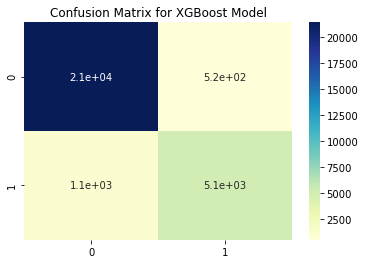

In [20]:
# accuracy of XGBoost Model
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,roc_curve, roc_auc_score
y_predxgb = xgbc.predict(X_test)
report = classification_report(y_test, y_predxgb)
print(report)
print("Accuracy of the XGBoost Model is:",accuracy_score(y_test,y_predxgb)*100,"%")
cm = confusion_matrix(y_test, y_predxgb)
sns.heatmap(cm, annot=True,cmap="YlGnBu")
plt.title("Confusion Matrix for XGBoost Model")
plt.show()
# Reference: https://towardsdatascience.com/getting-started-with-xgboost-in-scikit-learn-f69f5f470a97
# Reference: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package/code

The above classification report provides important metrices for the XGBoost regression model's performance.

The accuracy is at 93%.

The precision and recall are higher for predicting RainTomorrow values. The model is very efficient with predicing Yes-RainTomorrow.

With this experiment based on the dataset we have, we believe XGBoost model prediction is good based on precision and recall scores.

In [21]:
y_pred_proba = xgbc.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

Text(0.5, 1.0, 'ROC curve for XGBoost Classifier')

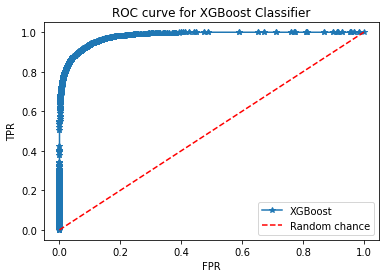

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(['XGBoost', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for XGBoost Classifier')

The receiver operating characteristic (ROC) curve is a plot of the pairs of true positive rates (y-axis) and false positive rates (x-axis) that result from lowering the threshold down from 1, all the way to 0.

Values closer to 1 in roc_auc_score shows that classifier is efficient and gives better performance.

The above `ROC` curve for the XGBoost model shows the area under the curve (AUC) for our top model. The score of 0.98 tells us that there is `98%` chance that the model will be successful at classifying yes as yes and no as no values for `RainTomorrow`.

### Feature Importance - XGBoost Model

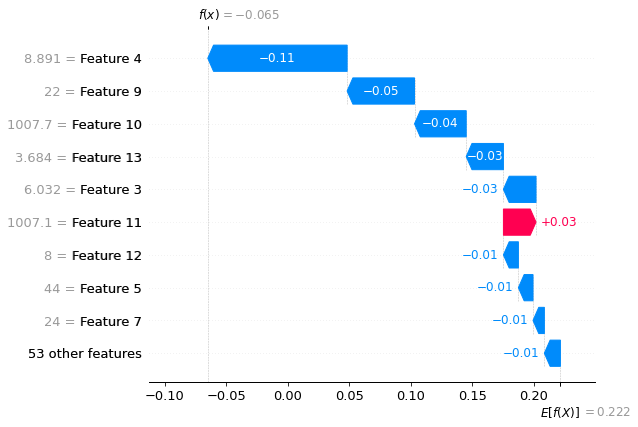

In [23]:
import xgboost
import shap
# train an XGBoost model
xgboost_model = xgboost.XGBRegressor().fit(X, y)
# explain the model's predictions using SHAP
explainer = shap.Explainer(xgboost_model, feature_names=df_model.columns)
shap_values = explainer(X)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# Reference: https://github.com/slundberg/shap

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output.

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

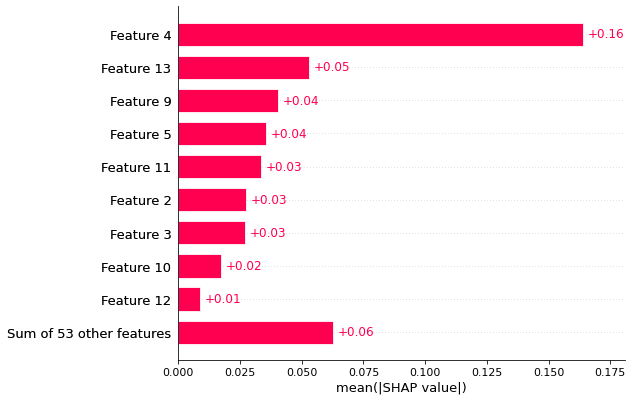

In [24]:
# feature inmportance using shap
shap.plots.bar(shap_values)
# Reference: https://github.com/slundberg/shap

The above plot shows the total impact of each feature on our model. As explained in previous weighted plot, these features have high importance in predicting `Feature 4 for RainTomorrow`.

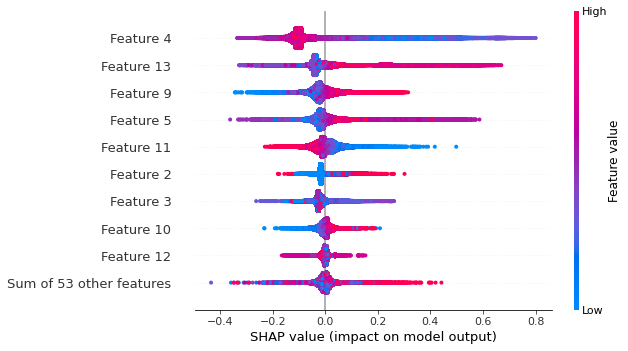

In [25]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)
# Reference: https://github.com/slundberg/shap

**Explaining the logistic model for Rain Tomorrow prediction:**

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. The above SHAP summary plot is made of many dots. Each dot has three characteristics:

The features are listed from high to low rank. The colors indicate how the change in the values of the features impact the output attribute (`Feature 4 for RainTomorrow`). For example, on above plot, `Feature 4 for RainTomorrow` shows the higher value of it has higher impact on the output. Horizontal location shows whether the effect of that value caused a higher or lower prediction.

Some things the summary plot is  able to easily pick out:-

Higher means more likely to be positive, so in the plots above the “red” features are actually helping raise the chance for `RainTomorrow`, while the negative features are lowering the chance for `RainTomorrow`.
The model ignored around 56 features which were of lower importance in predicting the chances of `RainTomorrow`.

Usually `Feature 11 for Pressure9am` has moderate effect on the prediction, but there are extreme cases of `Pressure9am` where a high value still caused moderate level of prediction.

Reference: https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

In [26]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])
# Reference: https://github.com/slundberg/shap

We predicted -0.02, whereas the base_value is 0.2216. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from feature being 1007.1. Though the blue feature next to the predicted value -0.02 has a meaningful effect decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

Reference: https://www.kaggle.com/dansbecker/shap-values

# Random Forest Classifier Model

In [27]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=300) # increasing number of trees for better accuracy
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

In [28]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=300) # increasing number of trees for better accuracy
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     21962
           1       0.91      0.80      0.85      6196

    accuracy                           0.94     28158
   macro avg       0.93      0.89      0.91     28158
weighted avg       0.94      0.94      0.94     28158

Accuracy of the Random Forest Model is: 93.85609773421407 %


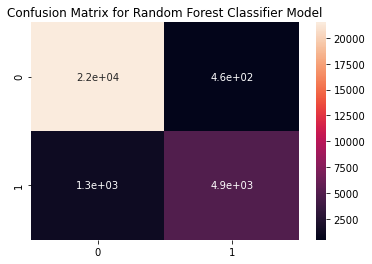

In [29]:
# accuracy of Random Forest Classifier Model
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,roc_curve, roc_auc_score
y_pred2 = classifier.predict(X_test)
report3 = classification_report(y_test, y_pred2)
print(report3)
print("Accuracy of the Random Forest Model is:",accuracy_score(y_test,y_pred2)*100,"%")
cm3 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm3, annot=True)
plt.title("Confusion Matrix for Random Forest Classifier Model")
plt.show()
# Reference: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# Reference: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package/code

In [30]:
y_pred_proba = classifier.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

Text(0.5, 1.0, 'ROC curve for Random Forest Classifier')

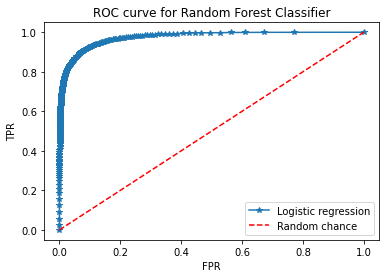

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(['Logistic regression', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Random Forest Classifier')

The receiver operating characteristic (ROC) curve is a plot of the pairs of true positive rates (y-axis) and false positive rates (x-axis) that result from lowering the threshold down from 1, all the way to 0.

Values closer to 1 in roc_auc_score shows that classifier is efficient and gives better performance.

The above `ROC` curve for the Random Forest model shows the area under the curve (AUC) for our top model. The score of 0.98 tells us that there is `98%` chance that the model will be successful at classifying yes as yes and no as no values for `RainTomorrow` 

# Tai

In [ ]:
df_model["RainTomorrow"] = df_model["RainTomorrow"].map(dict(Yes=1, No=0))
y= df_model["RainTomorrow"].values
del df_model["RainTomorrow"]
X = df_model.values
yhat = np.zeros(y.shape)
df_model["RainTomorrow"] = df_impute["RainTomorrow"]

In [ ]:

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])

    total_accuracy = mt.accuracy_score(y, yhat)
    print ('Random Forest accuracy', total_accuracy)

In [ ]:
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()

plot_class_acc(y,yhat,title="Random Forest")

In [ ]:
#List of decision trees - there are 150 decision trees

clf.estimators_


# it helps to see how many 'decision trees' are associated with our random forest model. 
# From the list, we can visualize some of the 'trees'. We are picking the first index

In [ ]:
#Decision tree diagram for the first index (first tree):

from sklearn import tree
plt.figure(figsize = (15,10))
tree.plot_tree(clf.estimators_[1], filled = True)

#Given the diagram below it is hard to visualize.

In [ ]:
#We cannot produce diagram for all decision trees in one instance. 
#We can visualize the data portion only for all the decision trees. 
#We can see how all the decision trees are being classified

for i in range(len(clf.estimators_)):
    print(tree.export_text(clf.estimators_[i]))


# Ravi

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.metrics import mean_squared_error

model_stats_columns=["Iteration", "MSE", "RMSE", "clf", "Time"]

def get_model_stats(model_clf,y_test, y_hat, target_names):
   
    mse = mean_squared_error(y_test,y_hat)
    rmse = mean_squared_error(y_test,y_hat, squared=False)

   
    # Create ROC Curve
    y_test_01 = np.where(y_test =="Yes", 1, [0])
    y_hat_01 = np.where(y_hat =="Yes", 1, [0])

    #Create a dict of these stats for class weight
    #dict will contain stats for balanced on one run, None for the next run

    stats_data = [mse, rmse]


    stats_row = stats_data 

    return stats_row





In [ ]:
#Linear Regression Model

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from timeit import default_timer as timer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

def create_lin_reg_models(df, iterations):
    
    X = None
    y = None
    if "Rainfall" in df:
        y = df["Rainfall"].values # get the labels we want
        del df["Rainfall"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    print (X)
    print (y)
    cv_data = ShuffleSplit(n_splits=iterations,
                             test_size  = 0.2, random_state = 123)
    
    
    cv_data.get_n_splits(X, y)
       
    #Initialize variables
    iter_num=1
    rows = []
    target_names = [0, 1]
    classes = None    
    scl_obj = StandardScaler()
    #lr_clf = LinearRegression(n_jobs=4)
    #lr_clf = linear_model.Lasso(alpha=0.1)
    #estimator = SVR(kernel="linear")
    estimator = LinearSVR(random_state=0, tol=1e-5)
    lr_clf = RFE(estimator, n_features_to_select=8, step=1)
    
    for train_indices, test_indices in cv_data.split(X,y): 
        starttime = timer()
        X_train = X[train_indices]
        y_train = y[train_indices]

        scl_obj.fit(X_train)

        X_test = X[test_indices]
        y_test = y[test_indices]
            
        try:
            X_train_scaled = scl_obj.transform(X_train) 
            X_test_scaled = scl_obj.transform(X_test)

            lr_clf.fit(X_train_scaled,y_train)  # train object
            y_hat = lr_clf.predict(X_test_scaled) # get test set precitions
            print(lr_clf.coef_)            
            model_stats = get_model_stats(lr_clf,y_test=y_test,y_hat=y_hat, target_names=target_names )

        except Exception as e:
            #print('Error:', str(e))
            raise
        endtime = timer()
        time_taken = endtime - starttime
        row = [iter_num] + model_stats + [lr_clf, time_taken]
        rows.append(row)
        iter_num+=1

    
    #Create a dataframe with the model stats 
    df_ret = pd.DataFrame(rows, columns = model_stats_columns)
    
    df_ret.plot.line(x='Iteration', y='RMSE')
    return df_ret



In [ ]:
#Random Forest

from sklearn.ensemble import RandomForestRegressor
from timeit import default_timer as timer

def create_random_forest_models(df, iterations):
    
    X = None
    y = None
    if "Rainfall" in df:
        y = df["Rainfall"].values # get the labels we want
        del df["Rainfall"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    print (X)
    print (y)
    cv_data = ShuffleSplit(n_splits=iterations,
                             test_size  = 0.2, random_state = 123)
    
    
    cv_data.get_n_splits(X, y)
       
    #Initialize variables
    iter_num=1
    rows = []
    target_names = [0, 1]
    scl_obj = StandardScaler()
    regr = RandomForestRegressor(max_depth=2, random_state=123)
    
    
    for train_indices, test_indices in cv_data.split(X,y): 
        starttime = timer()
        X_train = X[train_indices]
        y_train = y[train_indices]

        scl_obj.fit(X_train)
        
        X_test = X[test_indices]
        y_test = y[test_indices]
            
        try:
            X_train_scaled = scl_obj.transform(X_train) 
            X_test_scaled = scl_obj.transform(X_test)

            regr.fit(X_train_scaled,y_train)  # train object
            y_hat = regr.predict(X_test_scaled) # get test set precitions
            print(y_hat)
            
            model_stats = get_model_stats(regr,y_test=y_test,y_hat=y_hat, target_names=target_names )

        except Exception as e:
            #print('Error:', str(e))
            raise
        endtime = timer()
        time_taken = endtime - starttime
        row = [iter_num] + model_stats + [regr, time_taken]
        rows.append(row)
        iter_num+=1


    #Create a dataframe with the model stats 
    df_ret = pd.DataFrame(rows, columns = model_stats_columns)
    return df_ret



In [ ]:

df_model = df_model_copy.copy()
del df_model['RainTomorrow']
del df_model['IsRainToday']
del df_model['RainfallAmount']


df_ret = create_lin_reg_models(df=df_model,iterations=10)

In [ ]:
del df_model['RainTomorrow']
del df_model['IsRainToday']
del df_model['RainfallAmount']


In [36]:
def rain_classifier(row):
    if row["Rainfall"] > 30:
        return "High"
    elif row["Rainfall"] > 10 and row["Rainfall"] < 30:
        return "Moderate"
    elif row["Rainfall"] > 1 and row["Rainfall"] < 10:
        return "Low"
    else:
        return "None"

df_model["RainfallAmount"] = df_impute.apply(rain_classifier, axis=1)

df_model


,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,Wind9am_NW,Wind9am_S,Wind9am_SE,Wind9am_SSE,Wind9am_SSW,Wind9am_SW,Wind9am_W,Wind9am_WNW,Wind9am_WSW,RainfallAmount
0,13.4,22.9,6.032209,8.890686,44.0,20.0,24.0,71.0,22.0,1007.7,...,0,0,0,0,0,0,1,0,0,None
1,7.4,25.1,6.032209,8.890686,44.0,4.0,22.0,44.0,25.0,1010.6,...,0,0,0,0,0,0,0,0,0,None
2,12.9,25.7,6.032209,8.890686,46.0,19.0,26.0,38.0,30.0,1007.6,...,0,0,0,0,0,0,1,0,0,None
3,9.2,28.0,6.032209,8.890686,24.0,11.0,9.0,45.0,16.0,1017.6,...,0,0,1,0,0,0,0,0,0,None
4,17.5,32.3,6.032209,8.890686,41.0,7.0,20.0,82.0,33.0,1010.8,...,0,0,0,0,0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140782,3.5,21.8,6.032209,8.890686,31.0,15.0,13.0,59.0,27.0,1024.7,...,0,0,0,0,0,0,0,0,0,None
140783,2.8,23.4,6.032209,8.890686,31.0,13.0,11.0,51.0,24.0,1024.6,...,0,0,1,0,0,0,0,0,0,None
140784,3.6,25.3,6.032209,8.890686,22.0,13.0,9.0,56.0,21.0,1023.5,...,0,0,1,0,0,0,0,0,0,None
140785,5.4,26.9,6.032209,8.890686,37.0,9.0,9.0,53.0,24.0,1021.0,...,0,0,1,0,0,0,0,0,0,None


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def create_knn_model(df, response):
    # Split into training and test set
    
    y= df[response].values
    print(y)
    if response in df:
        del df[response]
    if "Rainfall" in df:
        del df["Rainfall"]
    if "RainTomorrow" in df:
        del df["RainTomorrow"]
#    if "IsRainToday" in df:    
#        del df["IsRainToday"]
    
    X = df.values

    pca = PCA(n_components = 2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)
    
    print(y_train)
    neighbors = np.arange(1, 9)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    
    

    # Loop over K values
    for i, k in enumerate(neighbors):
        #knn = KNeighborsClassifier(n_neighbors=k)
        knn =  DecisionTreeRegressor(random_state=123)
        X_train2 = pca.fit_transform(X_train)
        X_test2 =  pca.fit_transform(X_test)
        knn.fit(X_train2, y_train)

        # Compute traning and test data accuracy
        train_accuracy[i] = knn.score(X_train2, y_train)
        test_accuracy[i] = knn.score(X_test2, y_test)
        plt.figure(figsize=(10,8))
        plot_decision_regions(X_train2, y_train, clf=knn, legend=2)
       
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Knn with K='+ str(k))
        plt.show()
    # Generate plot
    plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy for ' + response)
    plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy for ' + response)

    plt.legend()
    plt.xlabel('n_neighbors')
    plt.ylabel('Accuracy')
    plt.show()
    
    
    #find the maximum accuracy and position
    best_k = test_accuracy.argmax()+1

    #Now use that K to predict

    yhat = np.zeros(y.shape) # we will fill this with predictions

    scl = StandardScaler()
    X = scl.fit_transform(X)

    # create cross validation iterator
    cv = StratifiedKFold(n_splits=10)

    # get a handle to the classifier object, which defines the type
    clf = KNeighborsClassifier(n_neighbors=best_k)

    # now iterate through and get predictions, saved to the correct row in yhat
    # NOTE: you can parallelize this using the cross_val_predict method
    for train, test in cv.split(X,y):
        clf.fit(X[train],y[train])
        yhat[test] = clf.predict(X[test])

    total_accuracy = mt.accuracy_score(y, yhat)
    return total_accuracy





In [ ]:
df_model_copy = df_model.copy()
try:
    create_knn_model(df=df_model.head(20000),response='RainTomorrow')
except Exception as e:
    print (e.message)
finally:
    df_model = df_model_copy.copy()

In [ ]:
y= df_model["RainfallAmount"].values
del df_model["RainfallAmount"]
del df_model["Rainfall"]
del df_model["RainTomorrow"]
del df_model["IsRainToday"]
X = df_model.values


In [ ]:
df_model["RainTomorrow"] = df_model["RainTomorrow"].map(dict(Yes=1, No=0))

In [ ]:
df_ret

In [ ]:
total_accuracy

In [ ]:
y

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()

iris.target

## Linear Regression Model

In Linear Regression Model, the dependent variable (`RainfallAmount`) is dependent of independent variables (the other 16 features). This is an instance of multiple linear regression, which means, the independent variable is dependent of multiple features.

Linear Regression works with continous variables and categorical variables doesn't translate well. To make categorical variables, we used One-hot encoding to convert them to numerical vectors. The downside of it, it may introduce multi-collineriaty, but we can minimize by taking only the important features.

There are multiple ways of doing Linear Regression, LASSO, Ridge and simple linear regression. We create models of all types and get the best model that has least RMSE values.

The function below builds linear regression models:

1. Ordinary Least squares

LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

2. LASSO
Linear Model trained with L1 prior as regularizer (aka the Lasso)

The optimization objective for Lasso is:

(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty).


3. RFE (Recursive Feature Elimination)

Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

We create models of these and then store them in a dataframe. We then compare the RMSE of these models, and find which model has lowest RMSE and take as the best model of Regression.

 
 #### References for definitions
 1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
 2. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
 3. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [ ]:
#Decision Trees

from sklearn.tree import DecisionTreeRegressor
from timeit import default_timer as timer
from sklearn.model_selection import cross_val_score

def create_decision_tree_models(df, iterations):
    
   
    if "Rainfall" in df:
        y = df["Rainfall"].values # get the labels we want
        del df["Rainfall"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    criterion = ["mse", "friedman_mse", "mae", "poisson"]
    
    for crit in criterion:
        regr = DecisionTreeRegressor(criterion=crit, random_state=123)
        score = cross_val_score(regr, X, y, cv=iterations, n_jobs=4)
        print(crit, score)
        #print(regr.tree_)

    #Create a dataframe with the model stats 
#    df_ret = pd.DataFrame(rows, columns = model_stats_columns)
    return None


In [ ]:
df_model = df_model_copy.copy()
if "RainTomorrow" in df_model:
    del df_model['RainTomorrow']

if "IsRainToday" in df_model:        
    del df_model['IsRainToday']

if "RainfallAmount" in df_model:   
    del df_model['RainfallAmount']
    
    
#df_model = df_model.select_dtypes(exclude=['uint8'])

create_models_classification(df=df_model,iterations=10)

In [ ]:
df_model_copy = df_model.copy()

In [ ]:
df_model.info()

In [47]:
#Create models

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso
from timeit import default_timer as timer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

def create_models_continous(model, df, iterations):

    X = None
    y = None
    if "Rainfall" in df:
        y = df["Rainfall"].values # get the labels we want
        del df["Rainfall"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    random_state = 123
    njobs = -1
    
    #models = ["LinearRegression", "Lasso", "LinearSVR"]
    models = ["LinearRegression", "Lasso"]

    for model in models:
        clf = None
        if model == "LinearRegression":
            clf = LinearRegression(n_jobs=njobs)
        elif model == "Lasso":
            clf = Lasso(alpha=0.1)
        elif model == "LinearSVR":    
            estimator = LinearSVR(random_state=0, tol=1e-5)
            clf = RFE(estimator, n_features_to_select=8, step=1)
    
        score = cross_val_score(model, X, y, cv=iterations, n_jobs=4, scoring="neg_root_mean_squared_error")
        abs_score = [abs(x) for x in score]
        print(model, abs_score)



        
def create_models_classification(model, df, response_feature,iterations):
    X = None
    y = None
    if response_feature in df:
        y = df[response_feature].values # get the labels we want
        del df[response_feature] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        print ("returning")
        return

    random_state = 123
    njobs = -1
    
    cv = StratifiedKFold(n_splits=iterations,shuffle=True, random_state=random_state)
    
    #models = ["LinearRegression", "Lasso", "LinearSVR"]

    score = cross_val_score(model, X, y, cv=iterations, n_jobs=4, scoring="accuracy")
    print(model, score)
    
        

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#df_model = df_model.select_dtypes(exclude=['uint8'])
models = [# KNeighborsClassifier(n_neighbors=8),
         GaussianNB(), 
    MultinomialNB(),
    SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3,max_iter=5, 
                  tol=None, n_jobs=-1, random_state=123),
    RandomForestClassifier(n_estimators=200, max_depth=3, 
                           n_jobs=-1, random_state=123),
    LinearSVC(random_state=123),
    LogisticRegression(n_jobs=-1, random_state=123)]
for model in models:
    df_model = df_model_copy.copy()
    if "RainTomorrow" in df_model:
        del df_model['RainTomorrow']

    if "IsRainToday" in df_model:        
        del df_model['IsRainToday']

    if "Rainfall" in df_model:   
        del df_model['Rainfall']
    
#    create_models_classification(model=model,df=df_model,response_feature="RainfallAmount", iterations=10)
    
for model in models:
    df_model = df_model_copy.copy()
    print("coming to models")
    if "RainfallAmount" in df_model:   
        del df_model['RainfallAmount']
        
    create_models_classification(model=model,df=df_model,response_feature="RainTomorrow", iterations=10)

coming to models
GaussianNB() [0.82101001 0.80907735 0.76944385 0.74912991 0.72064777 0.77675971
 0.76518219 0.85360136 0.82589857 0.81062651]
coming to models
MultinomialNB() [nan nan nan nan nan nan nan nan nan nan]
coming to models
SGDClassifier(alpha=0.001, max_iter=5, n_jobs=-1, random_state=123, tol=None) [0.86703601 0.84395199 0.83876696 0.8557426  0.79771291 0.80687549
 0.81475957 0.85729507 0.80473079 0.87427191]
coming to models
RandomForestClassifier(max_depth=3, n_estimators=200, n_jobs=-1,
                       random_state=123) [0.89502095 0.92961148 0.85673698 0.94275162 0.8582996  0.85638185
 0.89033312 0.88300895 0.90048302 0.88862054]
coming to models
LinearSVC(random_state=123) [0.89700973 0.87967895 0.81390724 0.86383976 0.62539953 0.77881952
 0.71318986 0.87064924 0.87064924 0.8859213 ]
coming to models
LogisticRegression(n_jobs=-1, random_state=123) [0.88955181 0.88912565 0.85489026 0.89267704 0.82655018 0.82683429
 0.85751829 0.87079131 0.86723966 0.8850689 ]


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

list_of_dir = df_impute.WindGustDir.unique()
le.fit(list_of_dir)
le.transform(df_impute.WindGustDir)

In [ ]:
gust_df = le.transform(df_impute.WindGustDir)
wind3pm_df = le.transform(df_impute.WindDir3pm)
wind9am_df = le.transform(df_impute.WindDir9am)

df_model["gust"] =  gust_df.tolist()
df_model["wind3pm"] =  wind3pm_df.tolist()
df_model["wind9am"] =  wind9am_df.tolist()

# Remove original categorical columns
df_model = df_model.drop(['WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainToday'], axis = 1)

df_model_copy = df_model.copy()


In [37]:
df_model_copy = df_model.copy()

In [32]:

df_model.RainfallAmount

0         0
1         0
2         0
3         0
4         0
         ..
140782    0
140783    0
140784    0
140785    0
140786    0
Name: RainfallAmount, Length: 140787, dtype: int64

In [57]:
df_model_copy = df_model.copy()

In [58]:
df_model_copy.RainTomorrow

0         No
1         No
2         No
3         No
4         No
          ..
140782    No
140783    No
140784    No
140785    No
140786    No
Name: RainTomorrow, Length: 140787, dtype: object

# Apurv

In [ ]:
df_model["RainTomorrow"] = df_model["RainTomorrow"].map(dict(Yes=1, No=0))
y= df_model["RainTomorrow"].values
del df_model["RainTomorrow"]
X = df_model.values
df_model["RainTomorrow"] = df_impute["RainTomorrow"]


Reference for KNN:
    
https://www.geeksforgeeks.org/k-nearest-neighbor-algorithm-in-python/

In [ ]:
%%time
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
  
  
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=123)
  
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
  
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
      
    # Compute traning and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
  
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
  
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


# create variables we are more familiar with

#y = df_model["RainTomorrow"].values # get the labels we want
#del df_model["RainTomorrow"] # get rid of the class label
#X = df_model.values
yhat = np.zeros(y.shape) # we will fill this with predictions

scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=8)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('KNN accuracy', total_accuracy)



In [ ]:
output= []
for x in yhat:
    if x not in output:
        output.append(x)
print(output)